In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas_profiling

from sklearn.decomposition import FactorAnalysis
from factor_analyzer.factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
data=pd.read_csv('C:/Users/ZomAdmin/Desktop/Data Science with python/Python Session 28/MAIN CASE STUDIES - ML/4. Segmentation of Credit Card Customers/CC_GENERAL.csv')

In [5]:
data.shape

(8950, 18)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [5]:
pandas_profiling_data=pandas_profiling.ProfileReport(data)
pandas_profiling_data.to_file('pandas_profiling_data.html')

### Deriving new KPI'S - KEY PERFORMANCE INDICATORS

#### 1st Kpi - Monthly average purchase and cash advance amount 

In [7]:
data.head(1)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.4,0.0,95.4,0.0,0.166667,0.0,0.083333,0.0,0,2,1000.0,201.802084,139.509787,0.0,12


In [9]:
data['Monthly_avg_purchase'] = data.PURCHASES / data.TENURE ### TENURE WISE PURCHASES 

In [11]:
data['Cash_adv_Amount']=data.CASH_ADVANCE / data.TENURE ## TENURE WISE CASH_ADVANCE_AMOUNT

#### 2nd Kpi - Purchases by type (one-off, installments)

In [13]:
data.ONEOFF_PURCHASES.count()

8950

In [14]:
data[(data['ONEOFF_PURCHASES']==0) & (data['INSTALLMENTS_PURCHASES']==0)].shape
data[(data['ONEOFF_PURCHASES']>0) & (data['INSTALLMENTS_PURCHASES']>0)].shape
data[(data['ONEOFF_PURCHASES']>0) & (data['INSTALLMENTS_PURCHASES']==0)].shape
data[(data['ONEOFF_PURCHASES']==0) & (data['INSTALLMENTS_PURCHASES']>0)].shape

(2260, 20)

In [16]:
def purchase(data):
    
   
    if (data['ONEOFF_PURCHASES']==0) & (data['INSTALLMENTS_PURCHASES']==0):
        return 'none'
    if (data['ONEOFF_PURCHASES']>0) & (data['INSTALLMENTS_PURCHASES']>0):
         return 'both_oneoff_installment'
    if (data['ONEOFF_PURCHASES']>0) & (data['INSTALLMENTS_PURCHASES']==0):
        return 'one_off'
    if (data['ONEOFF_PURCHASES']==0) & (data['INSTALLMENTS_PURCHASES']>0):
        return 'istallment'

In [21]:
data['purchase_type'] = data.apply(purchase,axis=1)

In [22]:
data.purchase_type.value_counts()

both_oneoff_installment    2774
istallment                 2260
none                       2042
one_off                    1874
Name: purchase_type, dtype: int64

### 3RD KPI - Limit usage (balance to credit limit ratio),

In [24]:
data['Limit_usage'] = data.BALANCE / data.CREDIT_LIMIT

In [25]:
data.MINIMUM_PAYMENTS.describe()

count     8637.000000
mean       864.206542
std       2372.446607
min          0.019163
25%        169.123707
50%        312.343947
75%        825.485459
max      76406.207520
Name: MINIMUM_PAYMENTS, dtype: float64

In [27]:
data.Limit_usage.describe()

count    8949.000000
mean        0.388926
std         0.389722
min         0.000000
25%         0.041527
50%         0.302870
75%         0.717582
max        15.909951
Name: Limit_usage, dtype: float64

### Outlier Treatment

In [30]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [32]:
data.head(1)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,...,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Monthly_avg_purchase,Cash_adv_Amount,purchase_type,Limit_usage
0,C10001,40.900749,0.818182,95.4,0.0,95.4,0.0,0.166667,0.0,0.083333,...,2,1000.0,201.802084,139.509787,0.0,12,7.95,0.0,istallment,0.040901


In [40]:
data.drop(columns = ['CUST_ID','purchase_type'],axis=1,inplace = True) ## Here we are dropping unnecessary columns:

KeyError: "['CUST_ID' 'purchase_type'] not found in axis"

In [53]:
round(data.apply(lambda x: continuous_var_summary(x)),2)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Monthly_avg_purchase,Cash_adv_Amount,Limit_usage
N,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00,8950.00,8949.00,8950.00,8637.00,8950.00,8950.00,8950.00,8950.00,8949.00
NMISS,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,313.00,0.00,0.00,0.00,0.00,1.00
SUM,14002049.71,7851.57,8978683.26,5302314.47,3679055.42,8760896.46,4388.64,1812.00,3261.71,1209.54,29077.00,131653.00,40220828.13,15511637.48,7464151.91,1375.75,103080.00,771267.80,796352.95,3480.50
MEAN,1564.47,0.88,1003.20,592.44,411.07,978.87,0.49,0.20,0.36,0.14,3.25,14.71,4494.45,1733.14,864.21,0.15,11.52,86.18,88.98,0.39
MEDIAN,873.39,1.00,361.28,38.00,89.00,0.00,0.50,0.08,0.17,0.00,0.00,7.00,3000.00,856.90,312.34,0.00,12.00,31.94,0.00,0.30
STD,2081.53,0.24,2136.63,1659.89,904.34,2097.16,0.40,0.30,0.40,0.20,6.82,24.86,3638.82,2895.06,2372.45,0.29,1.34,180.51,193.14,0.39
VAR,4332774.97,0.06,4565208.19,2755227.90,817827.43,4398096.33,0.16,0.09,0.16,0.04,46.58,617.90,13240979.88,8381394.16,5628502.90,0.09,1.79,32583.42,37301.56,0.15
MIN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.00,0.00,0.02,0.00,6.00,0.00,0.00,0.00
P1,0.07,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,500.00,0.00,19.52,0.00,6.00,0.00,0.00,0.00
P5,8.81,0.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1000.00,89.99,73.28,0.00,8.00,0.00,0.00,0.00


### Here we took log as part of outlier treatment by taking log we have squezzed the range

In [50]:
data1 = data.apply(lambda x:np.log(x+1))

In [51]:
data1.apply(lambda x: continuous_var_summary(x)) ## Here you can see that outliers are treated now

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Monthly_avg_purchase,Cash_adv_Amount,Limit_usage
N,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000
NMISS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,313.000000,0.000000,0.000000,0.000000,0.000000,1.000000
SUM,55146.653726,5548.460129,43851.841170,28678.252848,30004.010489,29705.819529,3233.344686,1420.355896,2417.140254,1015.936419,7317.251124,16957.839255,72440.675941,59289.634101,51149.999825,1053.685822,22551.138110,27305.346797,19367.534131,2649.918200
MEAN,6.161637,0.619940,4.899647,3.204274,3.352403,3.319086,0.361268,0.158699,0.270072,0.113512,0.817570,1.894731,8.094835,6.624540,5.922195,0.117730,2.519680,3.050877,2.163970,0.296113
MEDIAN,6.773521,0.693147,5.892417,3.663562,4.499810,0.000000,0.405465,0.080042,0.154151,0.000000,0.000000,2.079442,8.006701,6.754489,5.747301,0.000000,2.564949,3.494587,0.000000,0.264569
STD,2.013303,0.148590,2.916872,3.246365,3.082973,3.566298,0.277317,0.216672,0.281852,0.156716,1.009316,1.373856,0.819674,1.591763,1.190493,0.211617,0.130367,2.002823,2.429741,0.250298
VAR,4.053388,0.022079,8.508142,10.538886,9.504723,12.718484,0.076905,0.046947,0.079441,0.024560,1.018720,1.887481,0.671866,2.533708,1.417273,0.044782,0.016996,4.011300,5.903642,0.062649
MIN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.931826,0.000000,0.018982,0.000000,1.945910,0.000000,0.000000,0.000000
P1,0.063069,0.087011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.216606,0.000000,3.021616,0.000000,1.945910,0.000000,0.000000,0.000028
P5,2.283863,0.241162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.908755,4.510737,4.307869,0.000000,2.197225,0.000000,0.000000,0.002938


### Missing value Treatment

In [54]:
data1.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
Monthly_avg_purchase                  0
Cash_adv_Amount                       0
Limit_usage                           1
dtype: int64

In [56]:
data1.isna().sum() *100/ data1.isna().count()

BALANCE                             0.000000
BALANCE_FREQUENCY                   0.000000
PURCHASES                           0.000000
ONEOFF_PURCHASES                    0.000000
INSTALLMENTS_PURCHASES              0.000000
CASH_ADVANCE                        0.000000
PURCHASES_FREQUENCY                 0.000000
ONEOFF_PURCHASES_FREQUENCY          0.000000
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000
CASH_ADVANCE_FREQUENCY              0.000000
CASH_ADVANCE_TRX                    0.000000
PURCHASES_TRX                       0.000000
CREDIT_LIMIT                        0.011173
PAYMENTS                            0.000000
MINIMUM_PAYMENTS                    3.497207
PRC_FULL_PAYMENT                    0.000000
TENURE                              0.000000
Monthly_avg_purchase                0.000000
Cash_adv_Amount                     0.000000
Limit_usage                         0.011173
dtype: float64

In [67]:
data1['CREDIT_LIMIT'].fillna(data1['CREDIT_LIMIT'].mean(),inplace=True)
data1['MINIMUM_PAYMENTS'].fillna(data1['MINIMUM_PAYMENTS'].mean(),inplace=True)
data1['Limit_usage'].fillna(data1['Limit_usage'].mean(),inplace=True)

In [64]:
data.Limit_usage.mean()

0.38892640897649133

In [68]:
data1.isna().sum() *100/ data1.isna().count() ## Missing values have been imputed with mean

BALANCE                             0.0
BALANCE_FREQUENCY                   0.0
PURCHASES                           0.0
ONEOFF_PURCHASES                    0.0
INSTALLMENTS_PURCHASES              0.0
CASH_ADVANCE                        0.0
PURCHASES_FREQUENCY                 0.0
ONEOFF_PURCHASES_FREQUENCY          0.0
PURCHASES_INSTALLMENTS_FREQUENCY    0.0
CASH_ADVANCE_FREQUENCY              0.0
CASH_ADVANCE_TRX                    0.0
PURCHASES_TRX                       0.0
CREDIT_LIMIT                        0.0
PAYMENTS                            0.0
MINIMUM_PAYMENTS                    0.0
PRC_FULL_PAYMENT                    0.0
TENURE                              0.0
Monthly_avg_purchase                0.0
Cash_adv_Amount                     0.0
Limit_usage                         0.0
dtype: float64

<center>
<h1> Machine Learning

## Transformation of data

In [70]:
scaler = StandardScaler()
df_std=pd.DataFrame(scaler.fit_transform(data1))

In [72]:
df_std.head(1) ## Here we have made the data unitless for further analysis:

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-1.205218,-0.148757,-0.113532,-0.98709,0.39448,-0.930733,-0.746901,-0.73248,-0.674253,-0.72436,-0.810069,-0.57951,-1.447175,-0.824484,-0.835385,-0.556368,0.347262,-0.42903,-0.890667,-1.023002


In [90]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

### Here we are doing bartlett sphericity  test which is telling us that we have atleast two variables which are corelated to each other because the p_value which we are getting is <5%

In [94]:
chi_square_value,p_value = calculate_bartlett_sphericity(df_std)

In [95]:
chi_square_value,p_value ## We have two variables which are corelated with each other:

(248861.00316788195, 0.0)

In [96]:
df_std.shape ## We have 20 variables

(8950, 20)

In [ ]:
FactorAnalysis()

In [97]:
from factor_analyzer.factor_analyzer import FactorAnalyzer

### We are giving n_factors as 20 because we have 20 variables

In [99]:
fa=FactorAnalyzer(rotation=None,n_factors=20)

In [100]:
fa.fit(df_std)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=20, rotation=None, rotation_kwargs={},
               use_smc=True)

In [104]:
ev,v= fa.get_eigenvalues()
ev ## Eigen values of variables:

array([7.36533455e+00, 4.36985099e+00, 1.67167960e+00, 1.56704104e+00,
       1.20833898e+00, 8.95265665e-01, 7.26516141e-01, 5.49280496e-01,
       4.71669903e-01, 3.11166739e-01, 2.47080797e-01, 1.67767494e-01,
       1.32715767e-01, 1.07062294e-01, 7.40864649e-02, 4.74820579e-02,
       4.33750965e-02, 2.81019927e-02, 1.02659118e-02, 5.91801482e-03])

In [105]:
v ## Eigen values of variables:

array([ 7.34426073e+00,  4.30491754e+00,  1.61290399e+00,  1.49624319e+00,
        9.73448528e-01,  7.04436149e-01,  4.75664519e-01,  4.00421937e-01,
        2.98900715e-01,  2.66208897e-01,  2.16378605e-01,  1.11513310e-01,
        7.65269563e-02,  4.92039013e-02,  3.87435577e-02,  3.74306735e-02,
        2.54669360e-02,  9.28890700e-03,  3.65573650e-03, -4.15405701e-04])

### We can select only those factors whose eigenvalue > 1 means we will select only those factors where variance is atleast 1 unit

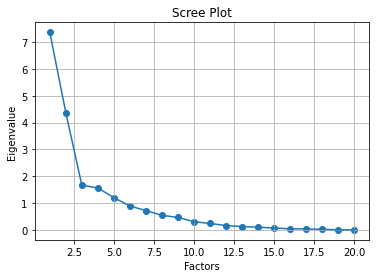

In [111]:
### Creating scree plot using matplotlib:
plt.scatter(range(1,df_std.shape[1]+1),ev)
plt.plot(range(1,df_std.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show() ## We have decided to go with 5 factors casue it has eigenvalue > 1

In [113]:
faq=FactorAnalyzer(n_factors=5,rotation=None)

In [114]:
faq.fit(df_std)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=5, rotation=None, rotation_kwargs={},
               use_smc=True)

### Here we have created dataframe with eigenvectors

In [116]:
x=pd.DataFrame(faq.loadings_)
x.columns = ['Factor_'+str(i) for i in range(1,6)]

In [117]:
x ## Here we have our 5 factors:

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,-0.387085,0.823846,-0.019735,-0.350173,0.161925
1,-0.031054,0.548868,0.110538,-0.249528,0.096937
2,0.854019,0.361500,-0.094487,0.055141,-0.134097
3,0.485097,0.485052,-0.648705,0.036144,-0.178020
4,0.731057,0.249793,0.498354,0.097588,0.041821
5,-0.780247,0.427242,0.072729,0.341957,-0.065419
6,0.838407,0.338830,0.260273,0.089765,-0.102036
7,0.479686,0.454343,-0.493947,0.067385,-0.080463
8,0.704990,0.239518,0.608064,0.087978,0.003905
9,-0.669867,0.450216,0.078984,0.367670,-0.116634


In [120]:
pd.concat([pd.DataFrame(data1.columns),x],axis=1).to_csv('factor_result.csv') ## EXPORTING FACTOR_ANALYSIS DATA

### Will again run the factor_analyzer with rotation as promax cause we are not seeing any trend in our exported csv as of now

In [121]:
faq1=FactorAnalyzer(n_factors=5,rotation='promax')

In [122]:
faq1.fit(df_std)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=5, rotation='promax',
               rotation_kwargs={}, use_smc=True)

In [123]:
x=pd.DataFrame(faq1.loadings_)
x.columns = ['Factor_'+str(i) for i in range(1,6)]

In [125]:
x.head()

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,-0.072957,0.127872,0.086021,0.785820,0.305052
1,0.201220,0.006794,0.000807,0.524659,0.165613
2,0.508133,-0.121657,0.535482,-0.004288,-0.057183
3,-0.239200,-0.046220,1.053595,0.048189,0.021481
4,1.024301,0.005267,-0.223316,-0.010713,0.009759


In [126]:
pd.concat([pd.DataFrame(data1.columns),x],axis=1).to_csv('factor_result_promax.csv') 

In [140]:
final_data=pd.concat([pd.DataFrame(data1.columns),x],axis=1)

### Factoranalysis

In [144]:
fac=FactorAnalysis(n_components=5)

In [145]:
fac.fit(df_std)

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=5,
               noise_variance_init=None, random_state=0,
               svd_method='randomized', tol=0.01)

In [147]:
components_df=pd.DataFrame(fac.components_)
for i in range(len(data1.columns)):
    components_df.rename(columns={i:data1.columns[i]},inplace=True)

### This plot is giving us the corelation value of every variable

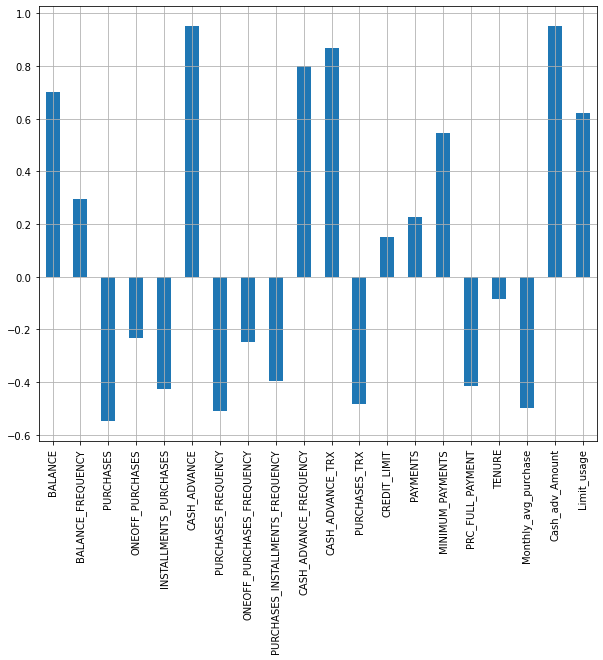

In [148]:
plt.figure(figsize=(10,8))
components_df.loc[0].plot(kind="bar")
plt.grid(True)

In [152]:
components_df.loc[0].sort_values() ## Now we will select the variables with high corelated values:

PURCHASES                          -0.549862
PURCHASES_FREQUENCY                -0.508884
Monthly_avg_purchase               -0.497650
PURCHASES_TRX                      -0.484005
INSTALLMENTS_PURCHASES             -0.424898
PRC_FULL_PAYMENT                   -0.415497
PURCHASES_INSTALLMENTS_FREQUENCY   -0.398205
ONEOFF_PURCHASES_FREQUENCY         -0.246677
ONEOFF_PURCHASES                   -0.233441
TENURE                             -0.085492
CREDIT_LIMIT                        0.151540
PAYMENTS                            0.225084
BALANCE_FREQUENCY                   0.295307
MINIMUM_PAYMENTS                    0.547085
Limit_usage                         0.619890
BALANCE                             0.700641
CASH_ADVANCE_FREQUENCY              0.798398
CASH_ADVANCE_TRX                    0.869813
CASH_ADVANCE                        0.950903
Cash_adv_Amount                     0.951998
Name: 0, dtype: float64

### Features to be used for further analysis will be based on the compnents with maximum variance

In [155]:
features = data1[['Cash_adv_Amount','CASH_ADVANCE','CASH_ADVANCE_TRX','CASH_ADVANCE_FREQUENCY','BALANCE','PURCHASES','PURCHASES_FREQUENCY',
'Monthly_avg_purchase','PURCHASES_TRX','INSTALLMENTS_PURCHASES']]

## Clustering

In [156]:
from sklearn.cluster import KMeans

In [160]:
final_data.head(1)

,0,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,BALANCE,-0.072957,0.127872,0.086021,0.78582,0.305052


In [163]:
cluster_range = range(1,10)
cluster_errors = []

for num in cluster_range:
    clusters = KMeans(num)
    clusters.fit(features)
    cluster_errors.append(clusters.inertia_)

In [164]:
cluster_errors ## These are the cluster errors

[426933.02821482514,
 208694.79293622408,
 129114.13551868791,
 96681.18674776024,
 79280.35247262457,
 63919.58672020785,
 57250.5009761506,
 53088.264615529195,
 48764.82221446096]

In [165]:
clusters_df = pd.DataFrame({'num_clusters':cluster_range,'cluster_errors':cluster_errors})
clusters_df ## Here we have made a dataframe which is showing cluster error:

,num_clusters,cluster_errors
0,1,426933.028215
1,2,208694.792936
2,3,129114.135519
3,4,96681.186748
4,5,79280.352473
5,6,63919.586720
6,7,57250.500976
7,8,53088.264616
8,9,48764.822214


### Within the region of elbow our ideal of k lies here bevause within this region maximum reduction of error happens:

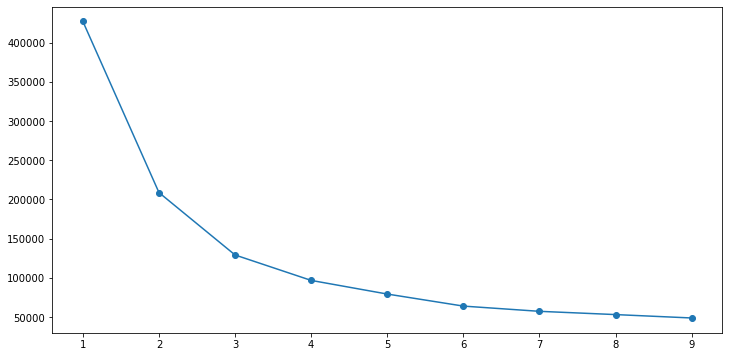

In [166]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

### Our ideal cluster value is 2

In [173]:
km_1= KMeans(n_clusters=2,random_state=1)

In [174]:
km_1.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [176]:
km_1.labels_ ## Here this means which obs is part of which cluster e.g here 0 means 1 1st obs is part of 1st cluster
## 2nd obs is part of 2nd cluster

array([0, 1, 0, ..., 0, 1, 1])

In [177]:
pd.Series(km_1.labels_).value_counts() ## Highest numbers are in 1 cluster, followed by 2nd cluster

0    4981
1    3969
dtype: int64

In [182]:
labels=km_1.labels_
labels

array([0, 1, 0, ..., 0, 1, 1])

In [188]:
labels

[0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,


In [189]:
labels=pd.Series(data=labels,index=range(len(labels)))

In [196]:
cluster_df_1 ## Here we have concatenated cluster with variables

,Cash_adv_Amount,CASH_ADVANCE,CASH_ADVANCE_TRX,CASH_ADVANCE_FREQUENCY,BALANCE,PURCHASES,PURCHASES_FREQUENCY,Monthly_avg_purchase,PURCHASES_TRX,INSTALLMENTS_PURCHASES,Cluster_1
0,0.000000,0.000000,0.000000,0.000000,3.735304,4.568506,0.154151,2.191654,1.098612,4.568506,0
1,6.287695,8.770896,1.609438,0.223144,8.071989,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,0.000000,0.000000,0.000000,0.000000,7.822504,6.651791,0.693147,4.180994,2.564949,0.000000,0
3,2.898616,5.331694,0.693147,0.080042,7.419183,7.313220,0.080042,4.835620,0.693147,0.000000,1
4,0.000000,0.000000,0.000000,0.000000,6.707735,2.833213,0.080042,0.847298,0.693147,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
8945,0.000000,0.000000,0.000000,0.000000,3.384170,5.677165,0.693147,3.902377,1.945910,5.677165,0
8946,0.000000,0.000000,0.000000,0.000000,3.004851,5.707110,0.693147,3.931826,1.945910,5.707110,0
8947,0.000000,0.000000,0.000000,0.000000,3.194529,4.979489,0.606136,3.221539,1.791759,4.979489,0
8948,1.959127,3.625907,1.098612,0.154151,2.671218,0.000000,0.000000,0.000000,0.000000,0.000000,1


In [199]:
# Mean value gives a good indication of the distribution of data. So we are finding mean value for each variable for each 
## cluster
cluster_1=cluster_df_1.groupby('Cluster_1')\
.apply(lambda x: x[features.columns].mean()).T
cluster_1

Cluster_1,0,1
Cash_adv_Amount,0.194485,4.635627
CASH_ADVANCE,0.361948,7.030223
CASH_ADVANCE_TRX,0.070498,1.755127
CASH_ADVANCE_FREQUENCY,0.008510,0.245288
BALANCE,5.323071,7.214017
PURCHASES,6.431694,2.976965
PURCHASES_FREQUENCY,0.494963,0.193483
Monthly_avg_purchase,4.025190,1.828136
PURCHASES_TRX,2.543686,1.080307
INSTALLMENTS_PURCHASES,4.693537,1.669313


In [209]:
cluster_df_1[cluster_df_1.Cluster_1 ==1].describe()

,Cash_adv_Amount,CASH_ADVANCE,CASH_ADVANCE_TRX,CASH_ADVANCE_FREQUENCY,BALANCE,PURCHASES,PURCHASES_FREQUENCY,Monthly_avg_purchase,PURCHASES_TRX,INSTALLMENTS_PURCHASES,Cluster_1
count,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.0
mean,4.635627,7.030223,1.755127,0.245288,7.214017,2.976965,0.193483,1.828136,1.080307,1.669313,1.0
std,1.280733,1.298860,0.787600,0.150313,1.413616,3.204793,0.255282,2.074300,1.327835,2.694209,0.0
min,0.917715,2.946687,0.693147,0.080042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,3.838812,6.221754,1.098612,0.133531,6.760893,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,4.803835,7.219534,1.609438,0.223144,7.408056,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,5.546631,7.952887,2.302585,0.348307,8.117049,6.162557,0.405465,3.761200,2.197225,4.463376,1.0
max,8.276166,10.760839,4.820282,0.916291,9.699282,10.003459,0.693147,7.519050,5.736572,9.211433,1.0


In [210]:
cluster_df_1[cluster_df_1.Cluster_1 ==0].describe()

,Cash_adv_Amount,CASH_ADVANCE,CASH_ADVANCE_TRX,CASH_ADVANCE_FREQUENCY,BALANCE,PURCHASES,PURCHASES_FREQUENCY,Monthly_avg_purchase,PURCHASES_TRX,INSTALLMENTS_PURCHASES,Cluster_1
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.0
mean,0.194485,0.361948,0.070498,0.008510,5.323071,6.431694,0.494963,4.025190,2.543686,4.693537,0.0
std,0.743842,1.337081,0.278528,0.035551,2.026243,1.345956,0.214374,1.280178,1.018366,2.690629,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080042,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,3.859914,5.574433,0.348307,3.180689,1.945910,3.903991,0.0
50%,0.000000,0.000000,0.000000,0.000000,5.494913,6.470784,0.559616,4.040123,2.564949,5.655992,0.0
75%,0.000000,0.000000,0.000000,0.000000,7.001238,7.384648,0.693147,4.945741,3.218876,6.566897,0.0
max,5.656785,8.138484,2.944439,0.510826,9.854515,10.800403,0.693147,8.315721,5.883322,10.021315,0.0
